# Introduction
In unsupervised machine learning, you are trying to find clusters in your data that the machine thinks "belong in the same group". There are many clustering algorithms that can help you label your unlabeled data. So the logical question would be: 

***"How do I know if the algorithm clustered my data correctly?"***

Since you don't have labels in an unsupervised problem, you can't compare the model's output with a set of answers. What you CAN do though in order to assess the performance of your model's output labels is a score called **Silhouette Score**. 

Without going in the details, silhouette score calculates *something like*: 

**"A ratio of the distance between a sample point with the mean distance of all other samples of the same class versus the distance of that same sample point with all other samples of a different class"**

Intuitively, the bigger the score, the farther it is with other sample points of a *different class*, and the closer it is with all other points of the *same class*. If a point is very close with other points of the same class, and very far away from points of all other different classes, then it's safe to say that the algorithm classified your point correctly.

In this notebook, I will show how two unsupervised learning algorithms, i.e. **K-Means** and **DBScan**, can label a set of dummy data, and how changing the hyperparameters can yield a different number of clusters and very different silhouette scores.

In [251]:
# custom transformer needs to inherit from these two base classes
from sklearn.base import BaseEstimator,TransformerMixin 

import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans,DBSCAN,MeanShift
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import datasets

from sklearn.metrics import silhouette_samples,silhouette_score,accuracy_score

We will use dummy data in the form of a dataframe. Even though we are focusing on assessing unsupervised learning algorithms and their silhouette scores, I'm including the real labels of our dummy data for comparison.

The data we will be using will be 3 dimensional with 4 different clusters. So now we know the *real* number of clusters is 4. Let's look at the silhouette score of our original labels.

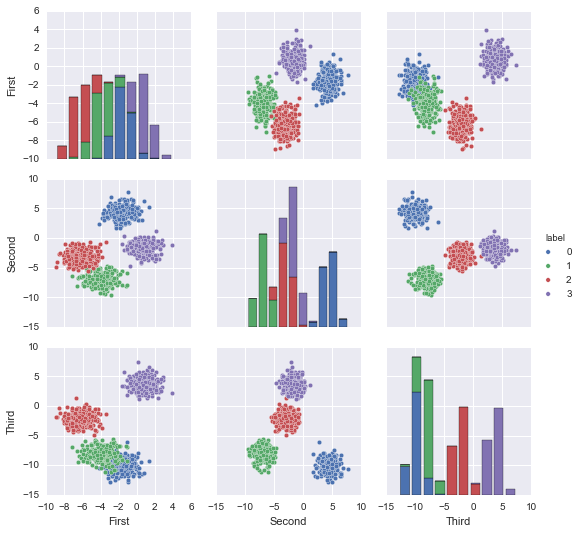

In [303]:
blobs = datasets.make_blobs(n_samples=1000,n_features=3,centers=4,cluster_std=1.0,random_state=1)
df = pd.DataFrame()
df['First'] = blobs[0][:,0]
df['Second'] = blobs[0][:,1]
df['Third'] = blobs[0][:,2]
df['label'] = blobs[1]

sns.pairplot(data=df,hue='label',vars=df.columns[0:3])
plt.show()

Silhouette scores are calcuated for each individual sample points. To visualize the scores, I like using boxplots grouped by the label each sample point belongs to.

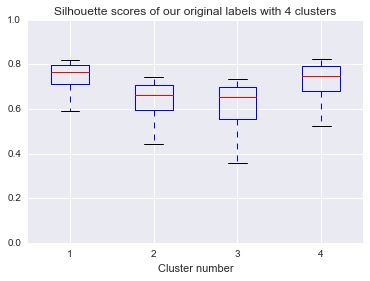

In [329]:
separation_scores = silhouette_samples(df.ix[:,0:2],df.ix[:,3])
x = []
for i in range(4):
    x.append(separation_scores[np.array(df.ix[:,3]==i)])
plt.boxplot(x)
plt.ylim(ymin=0,ymax=1)
plt.title('Silhouette scores of our original labels with 4 clusters')
plt.xlabel('Cluster number')
plt.show()

As you can see, the silhouette scores are relatively high. There are some samples whose scores are below 0.5, indicating that they are relatively close to sample points of other classes as well. This is fine because if you look at the colorful pairplot up there, you will see that some points in the original data set are indeed overlapping each other.

Knowing these silhouette scores reflect the "true" labels of our dummy data set, let's see if our unsupervised learning algorithms can achieve similar, or even better, silhouette scores.

## KMeans
Let's run KMeans and change one of the parameters, n_clusters, from 2 to 8. As the name suggests, this tells the algorithm to try to cluster the data into n_clusters. Knowing that our data only has 4 real clusters, we should see the best silhouette scores at n_clusters = 4.

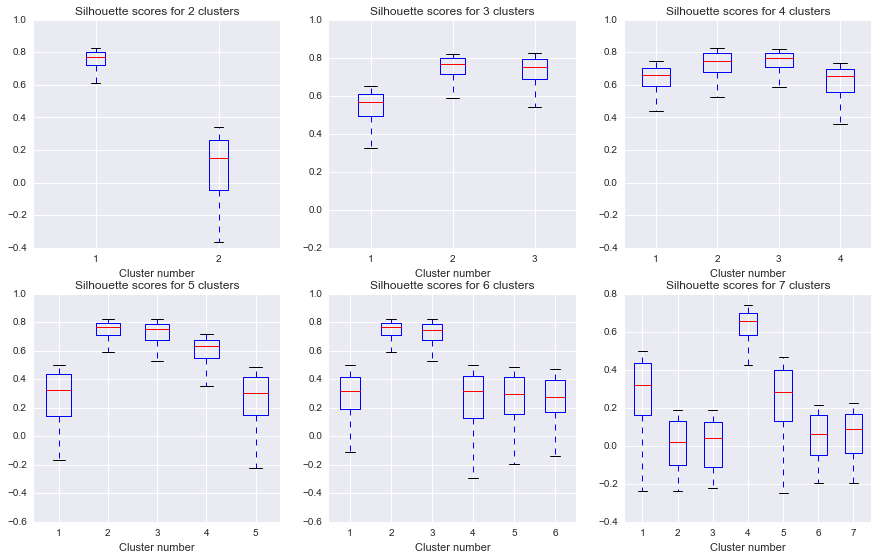

In [331]:
fig = plt.figure(figsize=(15,9))
k=1
nrows = 2
ncols = 3

for i in range(2,8):
    data = []
    k_means = KMeans(n_clusters=i)
    k_means.fit(df.ix[:,0:3])
    new_labels = k_means.labels_
    scores = silhouette_samples(df.ix[:,0:2],new_labels)
    
    for j in range(max(new_labels)+1):
        data.append(scores[np.array(new_labels==j)])
    ax = fig.add_subplot(nrows,ncols,k)
    ax.boxplot(data)
    ax.set_title('Silhouette scores for {} clusters'.format(i))
    ax.set_xlabel('Cluster number')
    k = k + 1

As expected, as we move away from n_clusters = 4, the silhouette scores for each cluster worsen. When we ask KMeans to make 7 clusters, you can see some scores go into the negative territory, which implies that a lot of sample points are overlapping, e.g. they are not optimally separated. If we have no prior knowledge of the correct number of labels for our data --the case for most unsupervised learning problems-- it's safe to say 7 clusters is definitely not the right number.

To drive the point home, let's look at how a pairplot looks like for n_cluster = 7.

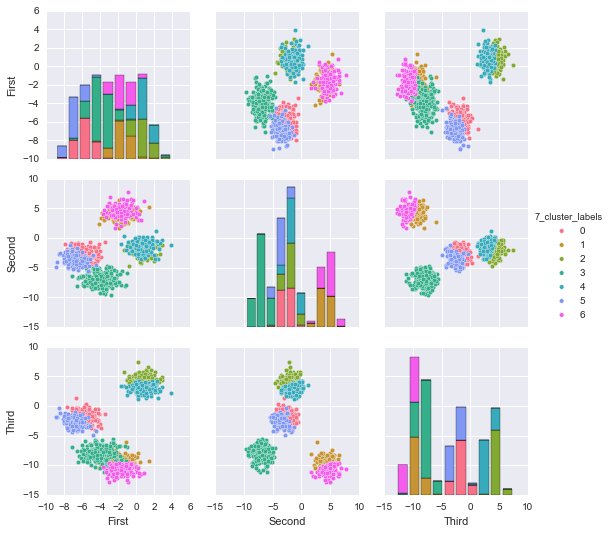

In [342]:
k_means = KMeans(n_clusters=7)
k_means.fit(df.ix[:,0:3])
df['7_cluster_labels'] = k_means.labels_

sns.pairplot(data=df,hue='7_cluster_labels',vars=df.columns[0:3])
plt.show()

As shown in the pairplot, KMeans with n_clusters = 7 separates our data into too many different blobs, with many overlapping data points.